# Generative Adversarial Network in TensorFlow

**Generative Adversarial Networks**, introduced by Ian Goodfellow in 2014, are neural nets we can train to _produce_ new images (or other kinds of data) that look as though they came from our true data distribution. In this notebook, we'll implement a small GAN for generating images that look as though they come from the MNIST dataset.

The key insight behind the GAN is to pit two neural networks against each other. On the one hand is the **Generator**, a neural network that takes random noise as input and produces an image as output. On the other hand is the **Discriminator**, which takes in an image and classifies it as real (from MNIST) or fake (from our Generator). During training, we alternate between training the Generator to fool the Discriminator, and training the Discriminator to call the Generator's bluff.

Implementing a GAN in Tensorflow will give you practice turning more involved models into working code, and is also a good showcase for Tensorflow's **variable scope** feature.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

## Loading the data

As in previous examples, we'll use MNIST, because it's a small and easy-to-use dataset that comes bundled with Tensorflow.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Utility functions

The `variables_from_scope` function lists all variables created within a given scope. This will be useful later, when we want to update all "discriminator" variables, but no "generator" variables, or vice versa.

In [4]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

We'll also provide a simple function for displaying a few 28-pixel images. This will help us understand the progress of our GAN as it trains; we'll use it to visualize the generated 'fake digit' images.

In [5]:
def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    #print(images.dtype)
    images = images*255
    images = images.astype(np.int32)
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

## Hyperparameters

Let's now set some hyperparameters, for use later on.

In [6]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 100000

## Generator

A GAN is made up of two smaller networks: a generator and a discriminator. The generator is responsible for sampling images from a distribution that we hope will get closer and closer, as we train, to the real data distribution.

Neural networks are deterministic, so in order to sample a new image from the generator, we first create some random noise `z` (in our case, `z` will be a 32-dimensional uniform random variable) and then feed that noise to the network. You can think of `z` as being a latent, low-dimensional representation of some image `G(z)`, though in a vanilla GAN, it is usually difficult to interpret `z`'s components in a meaningful way.

Our generator is a dead-simple multi-layer perceptron (feed-forward network), with 128 hidden units. We use sigmoid activation at the end, to make sure our output pixels are each in the range `[0, 1]` (with 0 as black, and 1 as white).

In [7]:
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

## Discriminator

Although it isn't necesssary, it makes some sense for our discriminator to mirror the generator's architecture, as we do here. The discriminator takes in an image (perhaps a real one from the MNIST dataset, perhaps a fake one from our generator), and attempts to classify it as real (1) or fake (0). Our architecture is again a simple MLP, taking 784 pixels down to 128 hidden units, and finally down to a probability.

Note that we will *reuse* this function, which builds the discriminator graph, twice. We give each layer a name, `D1` and `D2` respectively, so that when this function is called multiple times, tf.layers will be able to reuse the same variables for each "copy" of the graph that is created.

In [8]:
# Discriminator
def discriminator(images):
    hidden_layer = tf.layers.dense(images, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

## Building the graph

Given a generator and discriminator, we can now set up the GAN's computational graph. 

We use Tensorflow's variable scope feature for two purposes. 

1. First, it helps separate the variables used by the generator and by the discriminator; this is important, because when training, we want to alternate between updating each set of variables according to a different objective. 

2. Second, scoping helps us reuse the same set of discriminator weights both for the operations we perform on _real_ images and for those performed on _fake_ images. To achieve this, after calling `discriminator` for the first time (and creating these weight variables), we tell our current scope to `reuse_variables()`, meaning that on our next call to `discriminator`, existing variables will be reused rather than creating new ones.

In [9]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables()
    d_on_real = discriminator(real_X)

# Loss
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

##  (a) Training the GAN

Our training procedure is a bit more involved than in past demos. Here are the main differences:
1. Each iteration, we first train the generator, then (separately) the discriminator.
2. Each iteration, we need to feed in a batch of images, just as in previous notebooks. But we also need a batch of noise samples. For this, we use Numpy's `np.random.uniform` function.
3. Every 1000 iterations, we log some data to the console and visualize a few samples from our generator.

Iter [       0] Time [0.2129] d_loss [1.4423]


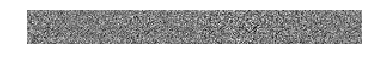

Iter [    1000] Time [1.4385] d_loss [0.0327]


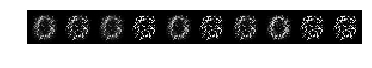

Iter [    2000] Time [2.7073] d_loss [0.0188]


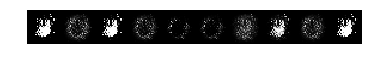

Iter [    3000] Time [3.9891] d_loss [0.1183]


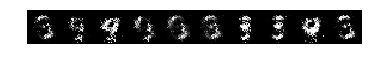

Iter [    4000] Time [5.2613] d_loss [0.1542]


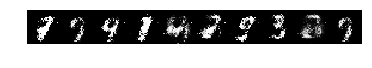

Iter [    5000] Time [6.5280] d_loss [0.2613]


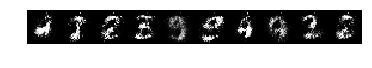

Iter [    6000] Time [7.7676] d_loss [0.1667]


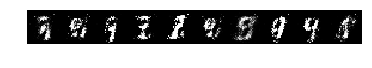

Iter [    7000] Time [9.0505] d_loss [0.1945]


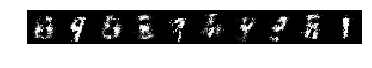

Iter [    8000] Time [10.3172] d_loss [0.6281]


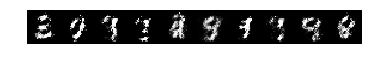

Iter [    9000] Time [11.6014] d_loss [0.4421]


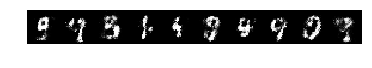

Iter [   10000] Time [12.8868] d_loss [0.6865]


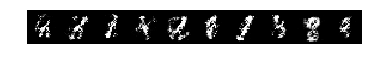

Iter [   11000] Time [14.1599] d_loss [0.7298]


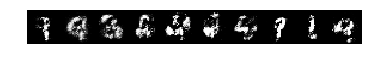

Iter [   12000] Time [15.3572] d_loss [0.4981]


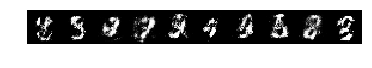

Iter [   13000] Time [16.6398] d_loss [1.1570]


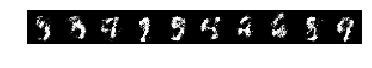

Iter [   14000] Time [17.9307] d_loss [0.6392]


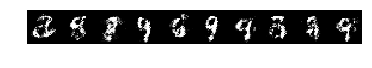

Iter [   15000] Time [19.2052] d_loss [0.9245]


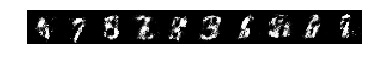

Iter [   16000] Time [20.4737] d_loss [0.6699]


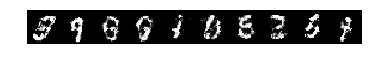

Iter [   17000] Time [21.6690] d_loss [0.7499]


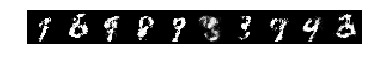

Iter [   18000] Time [22.9382] d_loss [0.9847]


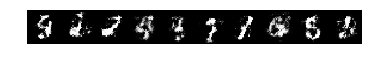

Iter [   19000] Time [24.2161] d_loss [0.9265]


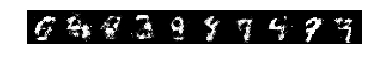

Iter [   20000] Time [25.4867] d_loss [0.6426]


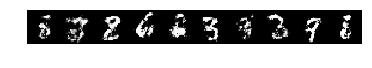

Iter [   21000] Time [26.7582] d_loss [0.6086]


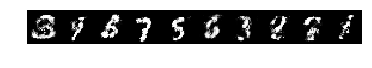

Iter [   22000] Time [28.0265] d_loss [0.8404]


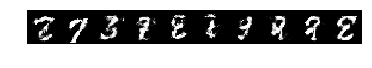

Iter [   23000] Time [29.2344] d_loss [0.8829]


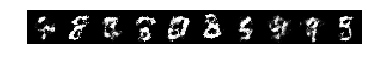

Iter [   24000] Time [30.5197] d_loss [0.8542]


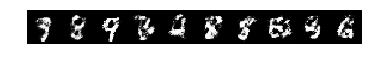

Iter [   25000] Time [31.8044] d_loss [0.8663]


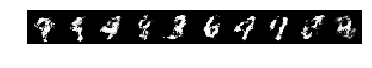

Iter [   26000] Time [33.0767] d_loss [0.7389]


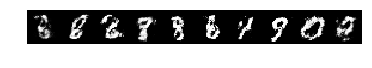

Iter [   27000] Time [34.3696] d_loss [0.6912]


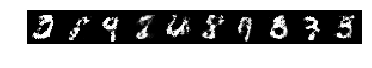

Iter [   28000] Time [35.5767] d_loss [0.8152]


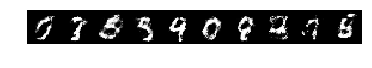

Iter [   29000] Time [36.8537] d_loss [0.7022]


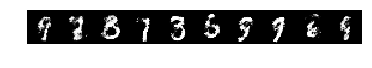

Iter [   30000] Time [38.1274] d_loss [1.1353]


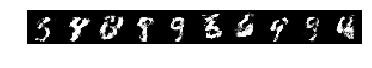

Iter [   31000] Time [39.3862] d_loss [0.7964]


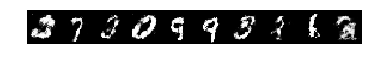

Iter [   32000] Time [40.7627] d_loss [0.7863]


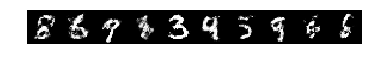

Iter [   33000] Time [42.0217] d_loss [0.9196]


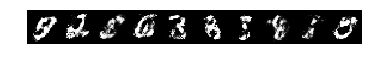

Iter [   34000] Time [43.2393] d_loss [0.7405]


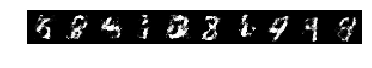

Iter [   35000] Time [44.5168] d_loss [0.8531]


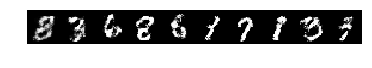

Iter [   36000] Time [45.7879] d_loss [0.7887]


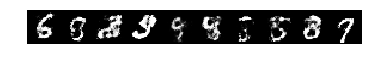

Iter [   37000] Time [47.0623] d_loss [0.7228]


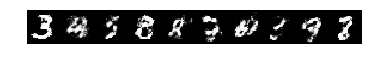

Iter [   38000] Time [48.3430] d_loss [0.6480]


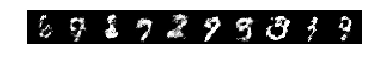

Iter [   39000] Time [49.5478] d_loss [1.0048]


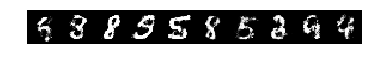

Iter [   40000] Time [50.8176] d_loss [0.6765]


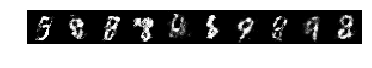

Iter [   41000] Time [52.0912] d_loss [0.7008]


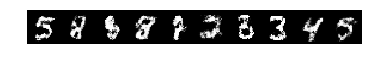

Iter [   42000] Time [53.3845] d_loss [0.7780]


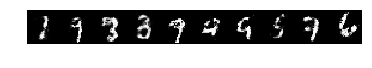

Iter [   43000] Time [54.6592] d_loss [0.5760]


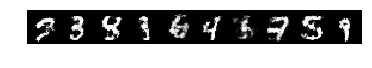

Iter [   44000] Time [55.9464] d_loss [0.5892]


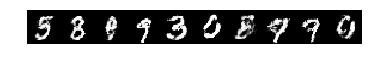

Iter [   45000] Time [57.1616] d_loss [0.7408]


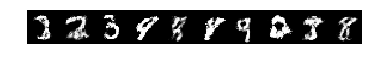

Iter [   46000] Time [58.4298] d_loss [0.7919]


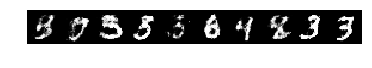

Iter [   47000] Time [59.7143] d_loss [0.7795]


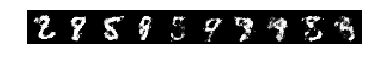

Iter [   48000] Time [60.9990] d_loss [0.7182]


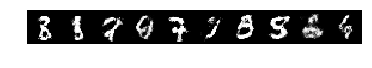

Iter [   49000] Time [62.2670] d_loss [0.5502]


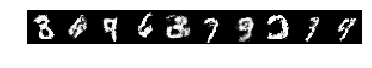

Iter [   50000] Time [63.4803] d_loss [0.8571]


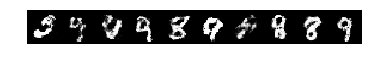

Iter [   51000] Time [64.7629] d_loss [0.7075]


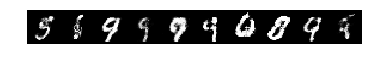

Iter [   52000] Time [66.0421] d_loss [0.8413]


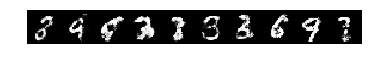

Iter [   53000] Time [67.3174] d_loss [0.5974]


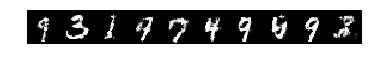

Iter [   54000] Time [68.5833] d_loss [0.7276]


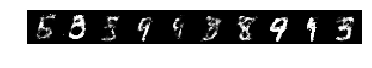

Iter [   55000] Time [69.8405] d_loss [0.6793]


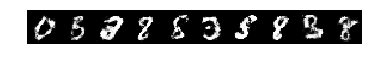

Iter [   56000] Time [71.0345] d_loss [0.7131]


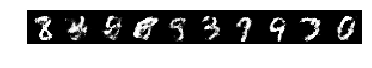

Iter [   57000] Time [72.3236] d_loss [0.6105]


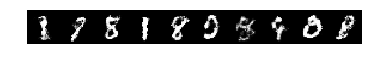

Iter [   58000] Time [73.6429] d_loss [0.9147]


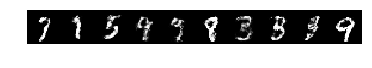

Iter [   59000] Time [74.9478] d_loss [0.7793]


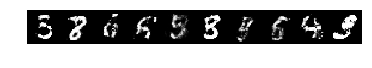

Iter [   60000] Time [76.2323] d_loss [0.7682]


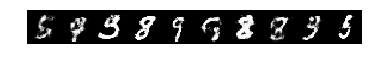

Iter [   61000] Time [77.4408] d_loss [0.6515]


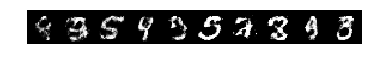

Iter [   62000] Time [78.7243] d_loss [0.8026]


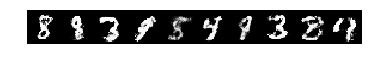

Iter [   63000] Time [79.9969] d_loss [0.8869]


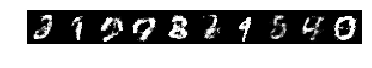

Iter [   64000] Time [81.2726] d_loss [0.8059]


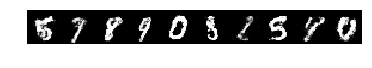

Iter [   65000] Time [82.5451] d_loss [0.5740]


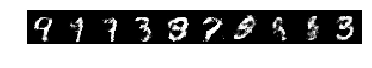

Iter [   66000] Time [83.8130] d_loss [0.8924]


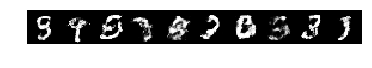

Iter [   67000] Time [85.0188] d_loss [0.7003]


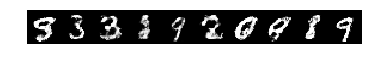

Iter [   68000] Time [86.3063] d_loss [0.8320]


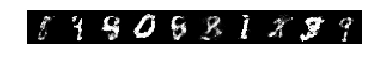

Iter [   69000] Time [87.5851] d_loss [0.6531]


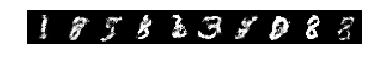

Iter [   70000] Time [88.8590] d_loss [0.8795]


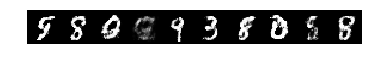

Iter [   71000] Time [90.1508] d_loss [0.5661]


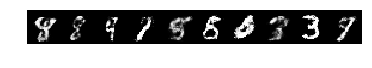

Iter [   72000] Time [91.3750] d_loss [0.7376]


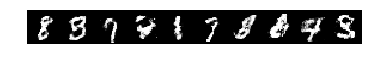

Iter [   73000] Time [92.6476] d_loss [0.7952]


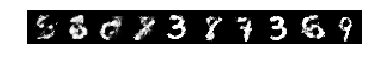

Iter [   74000] Time [93.9296] d_loss [0.8628]


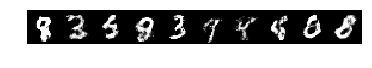

Iter [   75000] Time [95.1992] d_loss [0.7594]


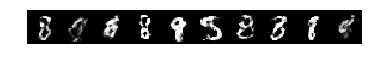

Iter [   76000] Time [96.4885] d_loss [0.6375]


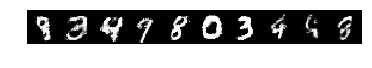

Iter [   77000] Time [97.7454] d_loss [0.6080]


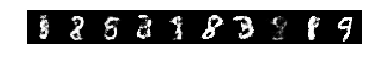

Iter [   78000] Time [98.9374] d_loss [0.7621]


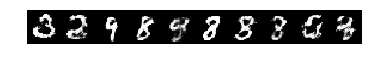

Iter [   79000] Time [100.2156] d_loss [1.0105]


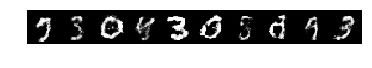

Iter [   80000] Time [101.4958] d_loss [1.0527]


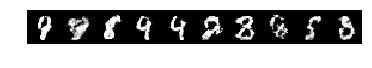

Iter [   81000] Time [102.7809] d_loss [0.8157]


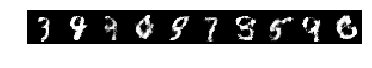

Iter [   82000] Time [104.0571] d_loss [0.8519]


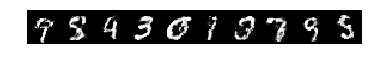

Iter [   83000] Time [105.2775] d_loss [0.8221]


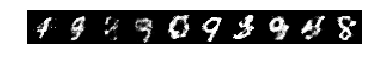

Iter [   84000] Time [106.5942] d_loss [0.6889]


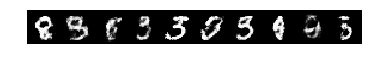

Iter [   85000] Time [107.8726] d_loss [0.8196]


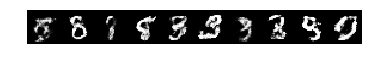

Iter [   86000] Time [109.1523] d_loss [0.6311]


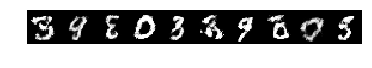

Iter [   87000] Time [110.4252] d_loss [0.6404]


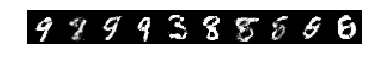

Iter [   88000] Time [111.6926] d_loss [0.5279]


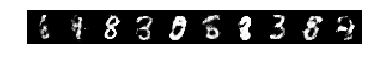

Iter [   89000] Time [112.9004] d_loss [0.7860]


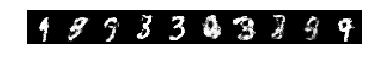

Iter [   90000] Time [114.1788] d_loss [0.6984]


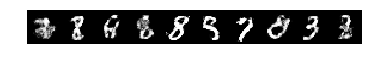

Iter [   91000] Time [115.5028] d_loss [0.6360]


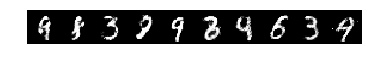

Iter [   92000] Time [116.7811] d_loss [0.8773]


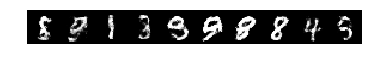

Iter [   93000] Time [118.0447] d_loss [0.8818]


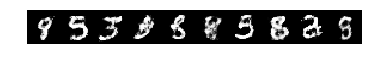

Iter [   94000] Time [119.2537] d_loss [0.6488]


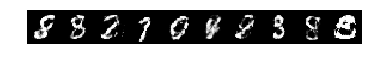

Iter [   95000] Time [120.5217] d_loss [0.5989]


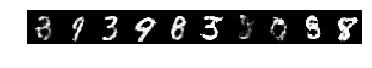

Iter [   96000] Time [121.8016] d_loss [0.6103]


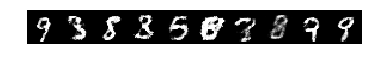

Iter [   97000] Time [123.0777] d_loss [0.6143]


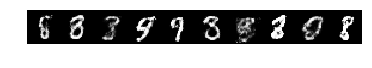

Iter [   98000] Time [124.3598] d_loss [0.6610]


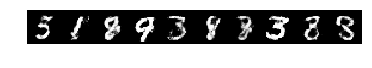

Iter [   99000] Time [125.6309] d_loss [0.7677]


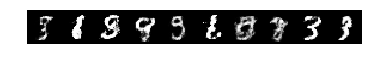

Iter [   99999] Time [126.8325] d_loss [0.7534]


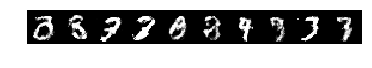

In [10]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(g_step, feed_dict=next_feed_dict())
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

##  (b) Generate some images and visualize

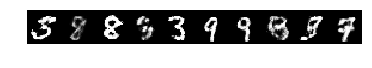

In [40]:
sample_batch_size = 10
sample_X = np.random.uniform(-1.0, 1.0, [sample_batch_size, z_dimension])

generated = sess.run(fake_X, feed_dict={z: sample_X})
visualize_row(generated)

##  (c) Pick two samples

ùúñ_start: [ 0.28477987  0.5407621   0.36331514 -0.04769358 -0.11690217  0.92131818
  0.08573124  0.70810647  0.81728132  0.70640914 -0.4211974  -0.62524415
  0.67193523 -0.38182382  0.02684539  0.60924046  0.14906653  0.78803454
  0.11602503 -0.97699055  0.46940876 -0.68650096 -0.83440724 -0.79847772
 -0.64806382  0.44550503  0.96800706 -0.77844227  0.86801944 -0.2610987
 -0.98711061 -0.1320321 ]
Generated image start:


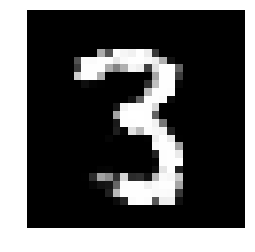

ùúñ_end: [-0.97428323  0.46071742  0.20980251  0.43611914  0.97081207  0.69820115
 -0.6394137  -0.79788584 -0.86194858 -0.67149816 -0.72731417 -0.74331431
 -0.73290631 -0.16700589  0.77392204 -0.2755286  -0.26995661 -0.32302742
 -0.82753705 -0.1644107  -0.2033023   0.85048147 -0.63663791 -0.69053501
 -0.26029622  0.35838431 -0.63708076 -0.99245226 -0.80725678 -0.34775156
  0.67997616  0.35578235]
Generated image end:


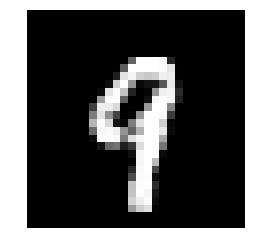

In [43]:
start_index = 4
end_index = 5

x_start = sample_X[start_index]
x_end = sample_X[end_index]

generated_start = np.reshape(generated, [-1,28,28])[start_index]
generated_end = np.reshape(generated, [-1,28,28])[end_index]

print("ùúñ_start:", x_start)
print("Generated image start:")
visualize_row(generated_start)

print("ùúñ_end:", x_end)
print("Generated image end:")
visualize_row(generated_end)




##  (d) Generate 10 steps between ùúñ_start and ùúñ_end

In [55]:
def linear_interp(z0, z1, step_num):
    steps = []
    for i in range(step_num):
        alpha = (i+1) / (step_num+1)
        z = (1 - alpha) * z0 + alpha * z1
        steps.append(z)
    return steps


step_num = 10
steps = linear_interp(x_start, x_end, step_num)

print(step_num, " steps between ùúñ_start and ùúñ_end:") 
for i in steps:
    print(i)


10  steps between ùúñ_start and ùúñ_end:
[ 0.17031959  0.53348531  0.34935944 -0.00371061 -0.01801906  0.90103481
  0.01980898  0.57119808  0.66462405  0.58114484 -0.4490262  -0.6359778
  0.54422236 -0.36229492  0.09476145  0.52880691  0.11097352  0.68702891
  0.03024666 -0.90311966  0.40825321 -0.54677529 -0.81642821 -0.78866475
 -0.61281222  0.43758496  0.82208999 -0.79789772  0.7157216  -0.26897624
 -0.83555726 -0.08768534]
[ 0.05585931  0.52620852  0.33540375  0.04027237  0.08086406  0.88075145
 -0.04611329  0.43428969  0.51196679  0.45588054 -0.47685499 -0.64671145
  0.4165095  -0.34276602  0.16267751  0.44837336  0.07288051  0.58602328
 -0.05553172 -0.82924876  0.34709766 -0.40704961 -0.79844918 -0.77885178
 -0.57756062  0.4296649   0.67617291 -0.81735317  0.56342376 -0.27685377
 -0.68400392 -0.04333857]
[-0.05860097  0.51893173  0.32144806  0.08425534  0.17974717  0.86046808
 -0.11203556  0.2973813   0.35930953  0.33061624 -0.50468379 -0.65744511
  0.28879663 -0.32323711  0.23

##  (e) Generate interpolation images and visualize them

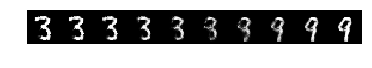

In [57]:
interp_generated = sess.run(fake_X, feed_dict={z: steps})
visualize_row(interp_generated)